## Import the necessary libraries

In [2]:
# Import the necessary libraries
import os
import sys

SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import scipy
from scipy.io import loadmat, savemat
from utils.data_utils import generate_trajectory_fixed_variances_pairs, generate_trajectory_modified_variances_pairs
from utils.plot_utils import plot_trajectories
import json
from src.rnn_models_NLSS_modified import RNN_model, push_model

In [3]:
import sys
print(sys.version)

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


In [6]:
with open('../log/estimate_theta_vars/gru_L2_H30_modified_RNN/gru_losses_eps2000_vars.json') as p:
    plot_data_gru = json.load(p)

with open('../log/estimate_theta_vars/gru_L2_H30_modified_RNN/gru_losses_eps3000_vars_2.json') as p:
    plot_data_gru_3000 = json.load(p)

with open('../log/estimate_theta_vars/lstm_L1_H60_modified_RNN/lstm_losses_eps3000_vars_2.json') as p:
    plot_data_lstm = json.load(p)

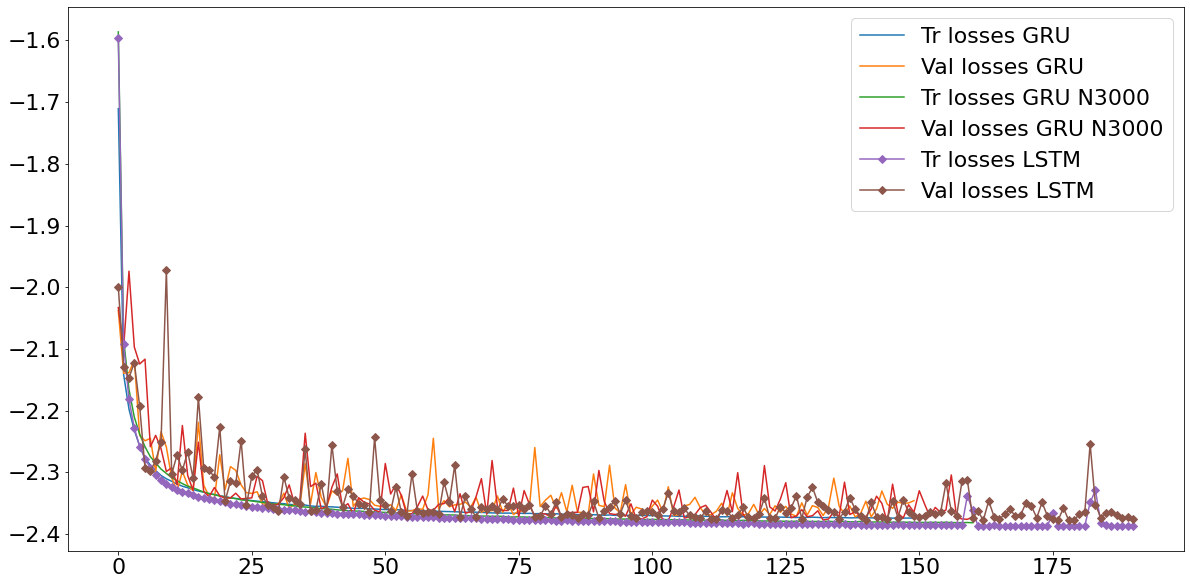

In [7]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot(np.log10(plot_data_gru['tr_losses']))
plt.plot(np.log10(plot_data_gru['val_losses']))
plt.plot(np.log10(plot_data_gru_3000['tr_losses']))
plt.plot(np.log10(plot_data_gru_3000['val_losses']))
plt.plot(np.log10(plot_data_lstm['tr_losses']), 'D-')
plt.plot(np.log10(plot_data_lstm['val_losses']), 'D-')
plt.legend(['Tr losses GRU', 'Val losses GRU', 'Tr losses GRU N3000', 'Val losses GRU N3000', 'Tr losses LSTM', 'Val losses LSTM'])
plt.show()

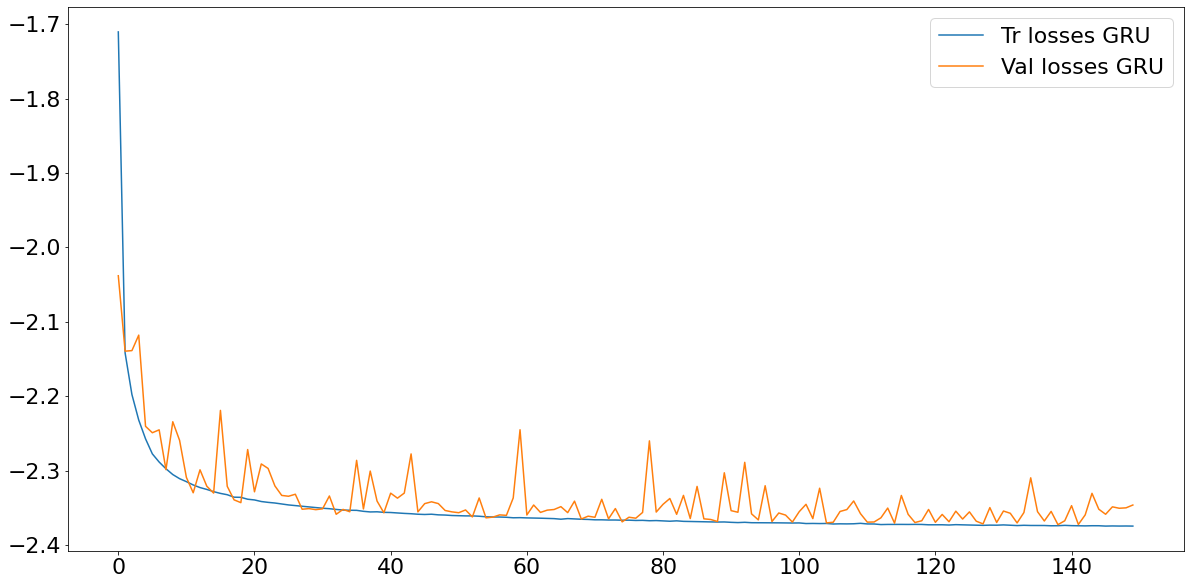

In [8]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
plt.plot(np.log10(plot_data_gru['tr_losses']))
plt.plot(np.log10(plot_data_gru['val_losses']))
plt.legend(['Tr losses GRU', 'Val losses GRU'])
plt.show()

In [9]:
# Set parameters for training data generation
N=200
M=100
P=1

In [10]:
# Load the dataset
Z_pM_test_sampled_theta = generate_trajectory_modified_variances_pairs(N, M=1, P=100, usenorm_flag=0)
#Z_pM_test_sampled_theta = loadmat('evaluation_data/variances/evaluation_DN_1000_N_200_samples_var.mat')

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [9]:
# Saving the created datasets
#savemat('./evaluation_data/variances/evaluation_ZN_{}_N_{}_fixed_samples_var_2.mat'.format(M*P, N), Z_pM_test_sampled_theta)

In [11]:
#Z_pM_test_fixed_theta = generate_trajectory_fixed_variances_pairs(N=N, M=100, P=1, usenorm_flag=0)
Z_pM_test_fixed_theta = loadmat('../evaluation_data/variances/evaluation_ZN_100_fixed_samples_latest.mat')

In [12]:
#savemat('evaluation_data/variances/evaluation_ZN_{}_fixed_samples_latest.mat'.format(M*P), Z_pM_test_fixed_theta)

<Figure size 1440x720 with 0 Axes>

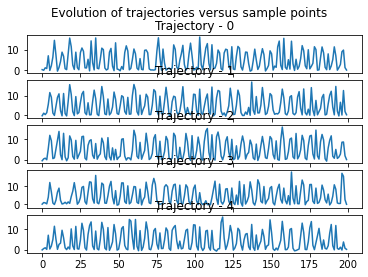

In [17]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20, 10))
plot_trajectories(Z_pM=Z_pM_test_fixed_theta, nrows=int(5), ncols=1)

In [18]:
# Importing the model configuration options
with open("../config/configurations_vars.json") as f:
    options = json.load(f)

### Load results from MATLAB model

In [19]:
res_matlab_method = loadmat('../matlab_results/results_ML_sampled_theta_pMCMC_MP100_latest_tuned_indices.mat')

In [20]:
mse_vec = res_matlab_method['res_MC_theta_fixed']['msevec'][-1][-1]
preds_vector = res_matlab_method['res_MC_theta_fixed']['preds_vector'][-1][-1]
default_mask = np.array([True]*int(M*P))
#default_mask = np.concatenate((np.array([True]*int(M*P)), np.array([False]*int(1000 - M*P))))
#default_mask[3] = False
#default_mask[63] = False

In [21]:
def get_chosen_idx(num_datasets=10, M=100, P=1):
    idx_chosen = np.random.choice(a=int(M*P), size=(num_datasets,), replace=False)
    print(idx_chosen)
    return idx_chosen

In [22]:
_ = get_chosen_idx(num_datasets=10, M=100, P=1)

[94 51 29 90  2 25 15 81 36 17]


In [23]:
len(default_mask)

100

In [24]:
default_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Analysis for GRU model

In [25]:
# Prediction using trained model
def compute_loss_using_saved_model(actual_data, actual_theta_vectors, best_saved_model, model_type, device, criterion=None, mask=None):
    te_running_loss = 0.0
    test_loss_epoch_sum = 0.0
    mask = mask.flatten()
    #mask = [True, True, False, False, True, True, True]
    with torch.no_grad():

        X_test = Variable(torch.from_numpy(actual_data), requires_grad=False).type(torch.FloatTensor).to("cpu")
        prediction_theta_vectors = best_saved_model.forward(X_test)
        print(prediction_theta_vectors[:10, :])
        prediction_theta_vectors = torch.cat((prediction_theta_vectors[:, :-2], 
                                              torch.square(prediction_theta_vectors[:, -2:])), dim=1)
        
        loss = criterion(prediction_theta_vectors[mask, :], torch.from_numpy(actual_theta_vectors.squeeze(2)[mask, :]))
        print("Loss for saved {} model is : {}".format(model_type, loss))
        print("-"*100)
    
    return loss, prediction_theta_vectors

In [26]:
# Define a function for loading model
def load_model_from_weights(model_type, model_file, device):
    #Load and Set model in evaluation mode
    model = RNN_model(**options[model_type]).to(device)
    model.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
    model = push_model(nets=model, device=device)
    model.eval()
    return model

In [27]:
np.set_printoptions(suppress=True)

In [28]:
def evaluate_using_saved_RNN_model(Z_pM_test, best_saved_model_file, model_type='gru', device='cpu', criterion=None, mask=None, sampled=False, savefig=None):
    
    # Define some criterion for evaluation if not specified already
    if criterion is None:
        criterion = nn.MSELoss(reduction='mean')
    
    # Load the saved model
    best_saved_model = load_model_from_weights(model_type, 
                                               best_saved_model_file, 
                                               device)
    
    # Print some shapes for sanity check
    # Print out some shapes for sanity check
    print(Z_pM_test_sampled_theta["data"][0][1].shape, 
          type(Z_pM_test_sampled_theta["data"][0][1]), 
          Z_pM_test_sampled_theta["data"][0][0].shape)
    
    # Get the data and targets separately as a numpy array
    actual_data = np.row_stack([np.expand_dims(Z_pM_test["data"][i][1], axis=0) for i in range(len(Z_pM_test["data"]))])
    actual_theta_vectors = np.row_stack([np.expand_dims(Z_pM_test["data"][i][0], axis=0) for i in range(len(Z_pM_test["data"]))])
    
    # Print shape of inputs and targets
    print("Input shape:{}, Targets shape:{}".format(actual_data.shape, actual_theta_vectors.shape))
    
    # Get loss, predictions
    loss, predicted_theta_vectors = compute_loss_using_saved_model(actual_data, 
                                                                   actual_theta_vectors, 
                                                                   best_saved_model, 
                                                                   model_type, 
                                                                   device,
                                                                   criterion,
                                                                   mask=mask)
    print("-"*100)
    print("Mean")
    print(torch.mean(predicted_theta_vectors, axis=0))
    print("-"*100)
    print("Covariance matrix")
    print(np.cov(predicted_theta_vectors.numpy(), rowvar=False))
    #plt.figure(figsize=(20, 10))
    #plt.imshow(np.cov(predicted_theta_vectors.numpy(), rowvar=False), vmin=0, vmax=1, interpolation='nearest')
    #plt.title('Covariance matrix for the 5-parameter results')
    print("-"*100)
    print("Prediction results")
    # Check one of the predictions
    # np.random.choice(100, (10,), replace=False)
    print(np.c_[predicted_theta_vectors[:10, :], actual_theta_vectors.squeeze(2)[:10, :]])
    
    # Prediction boxplots
    plt.rcParams["font.family"] = "serif"
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(12, 5))
    green_diamond = dict(markerfacecolor='r', marker='D')
    meanprops = dict(linewidth=3.0, color='green', linestyle='solid')
    medianprops = dict(linewidth=4.0, color='orange', linestyle='solid')
    
    if sampled == False:
        # theta_6

        plt.subplot(121)
        plt.boxplot(predicted_theta_vectors[:, 0].numpy(), showmeans=True, flierprops=green_diamond, notch=False,
                                                meanline=True, meanprops=meanprops, medianprops=medianprops)
        plt.grid(True)
        plt.xticks([1], [''])
        plt.title(r'$\theta_7$')
        #plt.axhline(actual_theta_vectors[0, 0], c='b')
        #plt.xticks(np.arange(0.3, 0.7, 5), str(np.arange(0.3, 0.7, 5)))

        # theta_7
        plt.subplot(122)
        plt.boxplot(predicted_theta_vectors[:, 1].numpy(), showmeans=True, flierprops=green_diamond, notch=False,
                                                meanline=True, meanprops=meanprops, medianprops=medianprops)
        plt.xticks([1], [''])
        plt.title(r'$\theta_8$')
        plt.grid(True)
        #plt.axhline(actual_theta_vectors[0, 1], c='b')
        
    else:
        # theta_6
        plt.subplot(121)
        plt.boxplot(predicted_theta_vectors[:, 0].numpy(), sym='r+', showmeans=True, meanline=True)
        #plt.axhline(np.mean(actual_theta_vectors, axis=0)[0], c='b')

        # theta_7
        plt.subplot(122)
        plt.boxplot(predicted_theta_vectors[:, 1].numpy(), sym='r+', showmeans=True, meanline=True)
        #plt.axhline(np.mean(actual_theta_vectors, axis=0)[1], c='b')
    
    if not savefig is None:
        plt.savefig(savefig)
    return loss, predicted_theta_vectors

### Evaluating the results for GRU model

Baseline MSE using MATLAB 0.007741573611799746
Evaluate for model:../models/gru_L2_H30_modified_RNN_var/gru_usenorm_0_ckpt_epoch_229_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.0416, 0.3773],
        [1.0280, 0.3377],
        [1.0595, 0.4220],
        [0.8510, 0.3691],
        [0.8939, 0.2641],
        [1.0465, 0.2994],
        [0.9116, 0.3481],
        [1.0042, 0.3406],
        [1.0867, 0.3188],
        [1.0885, 0.3392]])
Loss for saved gru model is : 0.011863441147208418
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([1.0304, 0.1024])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[ 0.02220669 -0.00038028]
 [-0.00038028  0.00082059]]
------------------------------------------------

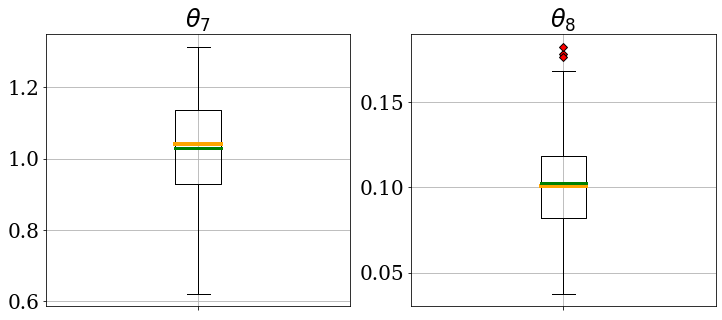

In [29]:
best_model_gru_model_vars = '../models/gru_L2_H30_modified_RNN_var/gru_usenorm_0_ckpt_epoch_229_best.pt'
print("Baseline MSE using MATLAB {}".format(np.mean(mse_vec[default_mask])))
print("Evaluate for model:{}".format(best_model_gru_model_vars))
gru_best_model_loss_vars, gru_best_model_predicted_theta_vectors_vars = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_vars,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask)

## For P=2000, M=500

Baseline MSE using MATLAB 0.007741573611799746
Evaluate for model:../models/gru_L2_H30_modified_RNN_var_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_150_best.pt
(200, 1) <class 'numpy.ndarray'> (2, 1)
Input shape:(100, 200, 1), Targets shape:(100, 2, 1)
tensor([[1.0212, 0.3288],
        [1.0103, 0.3257],
        [1.0684, 0.3763],
        [0.8825, 0.3187],
        [0.8674, 0.2369],
        [1.0281, 0.3324],
        [0.9031, 0.3335],
        [1.0078, 0.3556],
        [1.0041, 0.3371],
        [1.0266, 0.3039]])
Loss for saved gru model is : 0.00857754625936935
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Mean
tensor([0.9757, 0.0979])
----------------------------------------------------------------------------------------------------
Covariance matrix
[[0.01629125 0.00004949]
 [0.00004949 0.00043757]]
-------------------------------------

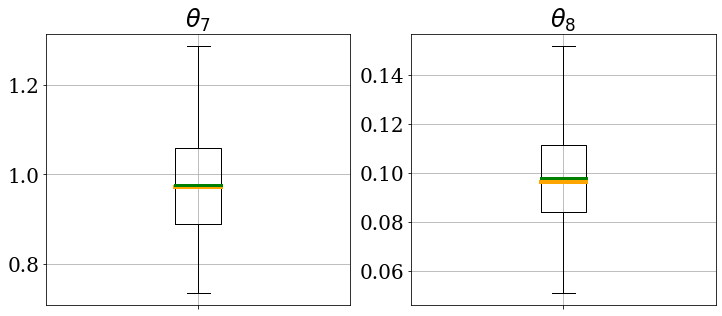

In [34]:
best_model_gru_model_vars_P2000_M500 = '../models/gru_L2_H30_modified_RNN_var_M500_P2000_N200/gru_usenorm_0_ckpt_epoch_150_best.pt'  
print("Baseline MSE using MATLAB {}".format(np.mean(mse_vec[default_mask])))
print("Evaluate for model:{}".format(best_model_gru_model_vars_P2000_M500))
gru_best_model_loss_vars_P2000_M500, gru_best_model_predicted_theta_vectors_vars_P2000_M500 = evaluate_using_saved_RNN_model(Z_pM_test=Z_pM_test_fixed_theta,
                                                                                             best_saved_model_file=best_model_gru_model_vars_P2000_M500,
                                                                                             model_type='gru',
                                                                                             device='cpu',
                                                                                             criterion=nn.MSELoss(reduction='mean'),
                                                                                             mask=default_mask,
                                                                                             savefig=None)

### Compare MATLAB and Python results over 10 randomly chosen datasets

In [35]:
idx_chosen = get_chosen_idx(num_datasets=10, M=100, P=1)
print(np.c_[idx_chosen.reshape((-1, 1)), np.square(preds_vector[idx_chosen, :]), gru_best_model_predicted_theta_vectors_vars_P2000_M500[idx_chosen, :]]) 

[96 48 55 47 25 17 23 27 60 16]
[[96.          0.87187554  0.09805963  0.78970605  0.09240438]
 [48.          1.00669656  0.08285416  0.9747681   0.06341595]
 [55.          0.94289184  0.08055831  0.90758699  0.07879488]
 [47.          1.26466849  0.10111101  1.19369578  0.12577744]
 [25.          0.87461673  0.08944556  1.00601292  0.08684463]
 [17.          1.0418341   0.09686393  1.03097558  0.09102361]
 [23.          1.13363291  0.11851099  1.12576926  0.10388602]
 [27.          1.103461    0.08423921  1.0397799   0.08553965]
 [60.          1.05811023  0.09111707  0.98170912  0.09122775]
 [16.          1.08431348  0.09481843  1.0057255   0.09430922]]
